### 1. Import modules

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pyodbc
import pandas as pd
import numpy as np
import xlwings as xw
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import geopandas as gpd

### 2. Import data to Pandas dataframe (Kidos_Observaties)

In [2]:
# Path to the password-protected Excel file
file_path = '4_Data/26062024_Oproeplijst.xlsx'
enc = 'Hi%V20mEDiDo$'

# Start an instance of Excel
app = xw.App(visible=False)

# Open the workbook with the password
wb = app.books.open(file_path, password=enc)

# Select the first sheet
sheet = wb.sheets[0]

# Read the data into a DataFrame
df = sheet.used_range.options(pd.DataFrame, header=1, index=False).value

# Close the workbook and quit the app
wb.close()
app.quit()

In [3]:
# Print the amount of unique clients in df
print(f'The amount of unique PersonNr\'s in the df is: {df['PersonNr'].nunique()}')

The amount of unique PersonNr's in the df is: 14111


In [4]:
# Create a boolean mask for rows where 'PersonNr' is a float
mask = df['PersonNr'].apply(lambda x: isinstance(x, float))

# Use the mask to filter df
df = df[mask]

# Cast 'PersonNr' to integer
df['Huisnummer'] = df['Huisnummer'].apply(lambda x: int(x))
df['PersonNr'] = df['PersonNr'].apply(lambda x: int(x))

# Save df['PersonNr'].unique() as a list of strings
person_nr = [str(x) for x in df['PersonNr'].unique()]

In [5]:
# Print the amount of unique clients in df
print(f'The amount of unique, valid PersonNr\'s in the df is: {df['PersonNr'].nunique()}')

The amount of unique, valid PersonNr's in the df is: 14047


In [6]:
# Set to True or False depending on whether you want to import new data
NEWIMPORT = False

if NEWIMPORT:
    # Replace server name if source changes
    server = 'AZ-ODB0\ODBWB'
    database = 'OnderzoeksDB_WB'

    # Create a connection string
    connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

    # Establish connection
    connection = pyodbc.connect(connection_string)

    # Define columns to select
    selected_columns = ['Clientnummer',
                        'ObservatieID',
                        'ContactmomentID',
                        'Contactmomenttype', 
                        'Contactmoment_BDS_Code',
                        'Contactmoment_BDS',
                        #'cohort_nr',
                        'Cohort',
                        'Observatiedatumtijd',
                        'Observatietype_code',
                        'Observatietype',
                        'Observatie_waarde',
                        'Tweeling',
                        'Buurt_BRP',
                        'CBS_Buurtcode_BRP',
                        'UitvoerendTeam',
                        'GeboortejaarmaandBiologischeMoeder',
                        'LeeftijdBiologischeMoederBijGeboorte',
                        'Geslacht',
                        'Geboorteland']

    # Create SQL query string with specific columns and inclusion criteria
    query = f'SELECT {', '.join(selected_columns)}, Geboortejaarmaand FROM Kidos_Observaties WHERE Clientnummer IN ({', '.join(person_nr)})'

    # Execute the query and fetch the data into a Pandas DataFrame
    df_observaties_og = pd.read_sql(query, connection)

    # Close the connection
    connection.close()

    # Save df_contactmomenten_og as a pickle
    df_observaties_og.to_pickle('4_Data\Pickles\observaties_schoolgaanden_og.pkl')
else:
    # Load the pickle
    df_observaties_og = pd.read_pickle('4_Data\Pickles\observaties_schoolgaanden_og.pkl')

In [7]:
print(f'The amount of unique \'Clientnummer\'s found in Kidos is: {len(df_observaties_og['Clientnummer'].unique())}')

The amount of unique 'Clientnummer's found in Kidos is: 13765


In [8]:
# Set to True or False depending on whether you want to import new data
NEWIMPORT = False

if NEWIMPORT:
    # Replace server name if source changes
    server = 'AZ-ODB0\ODBWB'
    database = 'OnderzoeksDB_WB'

    # Create a connection string
    connection_string = f'DRIVER={{SQL Server}};SERVER={server};DATABASE={database}'

    # Establish connection
    connection = pyodbc.connect(connection_string)

    # Define columns to select
    selected_columns = ['FK_CLIENT_ID',
                        'TOESTEMMINGSVRAAG',
                        'ANTWOORD',
                        'BEGINDATUM']

    # Define a list of Clientnummers to include
    included_clientnummers = df_observaties_og['Clientnummer'].unique()
    print(len(included_clientnummers))

    # Create SQL query string with specific columns and inclusion criteria
    query = f'SELECT {', '.join(selected_columns)} FROM Kidos_TOESTEMMINGEN WHERE FK_CLIENT_ID IN ({', '.join(included_clientnummers)})'

    # Execute the query and fetch the data into a Pandas DataFrame
    df_toestemmingen_og = pd.read_sql(query, connection)

    # Close the connection
    connection.close()

    # Save df_contactmomenten_og as a pickle
    df_toestemmingen_og.to_pickle('4_Data\Pickles\\toestemmingen_schoolgaanden_og.pkl')
else:
    # Load the pickle
    df_toestemmingen_og = pd.read_pickle('4_Data\Pickles\\toestemmingen_schoolgaanden_og.pkl')

#### 2.1 Drop clients with objection

In [9]:
# Store copy of unique records of df_og in df
df_toestemmingen = df_toestemmingen_og.drop_duplicates()

# Remove all rows where Observatie_waarde != 'Toestemming gegevensuitwisseling RVP'
toestemmingen_oz = df_toestemmingen[df_toestemmingen['TOESTEMMINGSVRAAG'] == 'Bezwaar wetenschappelijk onderzoek']

# Get most recent 'toestemmingen'
schoolgaanden_toestemmingen_oz = toestemmingen_oz.groupby('FK_CLIENT_ID')['BEGINDATUM'].idxmax()

# Get all the indices (.values) from the df
most_recent = toestemmingen_oz.loc[schoolgaanden_toestemmingen_oz.values]

# Select only constant variables, observaties will be added later
schoolgaanden_toestemmingen = most_recent[['FK_CLIENT_ID', 'ANTWOORD']]

# Save objection schoolgaanden
schoolgaanden_objection = list(schoolgaanden_toestemmingen[schoolgaanden_toestemmingen['ANTWOORD'] == 'wel bezwaar']['FK_CLIENT_ID'].astype(int))

# Get only rows from 'Oproeplijst'/df where Clientnummer is not in schoolgaanden_objection
df_observaties_og = df_observaties_og[~df_observaties_og['Clientnummer'].isin(schoolgaanden_objection)]

In [10]:
print(f'The amount of observations in the df is: {len(df_observaties_og['Clientnummer'])}, the amount of unique client ID\'s is: {len(df_observaties_og['Clientnummer'].unique())}')

The amount of observations in the df is: 1204892, the amount of unique client ID's is: 13765


#### 2.2 Get constant variables and relevant observation types

In [11]:
# Store copy of unique records of df_og in df
df_observaties = df_observaties_og.drop_duplicates()

In [12]:
# Sort the df by 'Observatiedatumtijd'
df_observaties = df_observaties.sort_values(by='Observatiedatumtijd', ascending=True)

##### 2.2.1 Geboortejaarmaand

In [13]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboortejaarmaand'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand_overall = df_observaties.loc[mask, ['Clientnummer', 'Geboortejaarmaand']]

In [14]:
# Convert 'Geboortejaarmaand' to Month date type
geboortejaarmaand_overall['Geboortejaarmaand'] = pd.to_datetime(geboortejaarmaand_overall['Geboortejaarmaand'], format='%Y%m').dt.to_period('M')

In [15]:
geboortejaarmaand_overall.isna().mean()

Clientnummer         0.0
Geboortejaarmaand    0.0
dtype: float64

##### 2.2.2 Tweeling

In [16]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Tweeling'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
tweeling_overall = df_observaties.loc[mask, ['Clientnummer', 'Tweeling']]

In [17]:
tweeling_overall.isna().mean()

Clientnummer    0.0
Tweeling        0.0
dtype: float64

##### 2.2.3 Buurt_BRP

In [18]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Buurt_BRP'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
buurt_brp_overall = df_observaties.loc[mask, ['Clientnummer', 'Buurt_BRP']]

In [19]:
buurt_brp_overall.isna().mean()

Clientnummer    0.0
Buurt_BRP       0.0
dtype: float64

##### 2.2.4 CBS_Buurtcode_BRP

In [20]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['CBS_Buurtcode_BRP'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
cbs_buurtcode_overall = df_observaties.loc[mask, ['Clientnummer', 'CBS_Buurtcode_BRP']]

In [21]:
cbs_buurtcode_overall.isna().mean()

Clientnummer         0.0
CBS_Buurtcode_BRP    0.0
dtype: float64

##### 2.2.5 GeboortejaarmaandBiologischeMoeder

In [22]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['GeboortejaarmaandBiologischeMoeder'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand_biologischemoeder_overall = df_observaties.loc[mask, ['Clientnummer', 'GeboortejaarmaandBiologischeMoeder']]

In [23]:
# Set GeboortejaarmaandBiologischeMoeder to NaN if it is '00'
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'].replace('00', np.NaN)

# Change the data type of the column to string
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'].astype(str)

# If the length of the string is 5, add 1 as its first character
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'].apply(lambda x: '1' + x if len(x) == 5 else x)

# If the second character is a 0, replace it with a 9
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'].apply(lambda x: x[:1] + '9' + x[2:] if (x[0] == '1' and x[1] == '0') else x)

# Replace "onbekend" with np.nan
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'].replace('onbekend', np.nan)

# Change month dtypes
geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'] = pd.to_datetime(geboortejaarmaand_biologischemoeder_overall['GeboortejaarmaandBiologischeMoeder'], format='%Y%m').dt.to_period('M').dt.strftime('%Y-%m')

In [24]:
geboortejaarmaand_biologischemoeder_overall.isna().mean()

Clientnummer                          0.000000
GeboortejaarmaandBiologischeMoeder    0.250272
dtype: float64

##### 2.2.6 LeeftijdBiologischeMoederBijGeboorte

In [25]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['LeeftijdBiologischeMoederBijGeboorte'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
leeftijd_biologischemoeder_overall = df_observaties.loc[mask, ['Clientnummer', 'LeeftijdBiologischeMoederBijGeboorte']]

In [26]:
leeftijd_biologischemoeder_overall.isna().mean()

Clientnummer                            0.0
LeeftijdBiologischeMoederBijGeboorte    0.0
dtype: float64

##### 2.2.7 Geslacht

In [27]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geslacht'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geslacht_overall = df_observaties.loc[mask, ['Clientnummer', 'Geslacht']]

In [28]:
geslacht_overall.isna().mean()

Clientnummer    0.0
Geslacht        0.0
dtype: float64

##### 2.2.8 Geboorteland

In [29]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboorteland'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboorteland_overall = df_observaties.loc[mask, ['Clientnummer', 'Geboorteland']]

In [30]:
geboorteland_overall.isna().mean()

Clientnummer    0.0
Geboorteland    0.0
dtype: float64

### 3. Transform rows from observations to clients

#### 3.1 Show unique clients vs. df rows

In [31]:
print(f'The amount of observations in the df is: {len(df_observaties)}, the amount of unique client ID\'s with one of the relevant observation types is: {len(df_observaties['Clientnummer'].unique())}')

The amount of observations in the df is: 1203868, the amount of unique client ID's with one of the relevant observation types is: 13765


In [32]:
print(f'The amount of observations in the df is: {len(df)}, the amount of unique client ID\'s is: {len(df['PersonNr'].unique())}')

The amount of observations in the df is: 33906, the amount of unique client ID's is: 14047


#### 3.2 Create overview of vaccinations per client ID

In [33]:
# Filter rows where 'Observatietype' is in the predefined list of relevant values
observaties_relevant = ['B.M.R.',
                        'DTP',
                        'Pneu',
                        'DKTP-Hib-Hepatitis B',
                        'DKTP',
                        'MenC',
                        'MenACWY',
                        'Hib',
                        'DKTP-booster',
                        'DKTP-Hepatitis B',
                        'DKTP-Hib']
df_observaties = df_observaties[df_observaties['Observatietype'].isin(observaties_relevant)]

In [34]:
for column in df_observaties:
    print(f'\'{column}\': \'{df_observaties[column].dtype}\',')

'Clientnummer': 'object',
'ObservatieID': 'object',
'ContactmomentID': 'object',
'Contactmomenttype': 'object',
'Contactmoment_BDS_Code': 'object',
'Contactmoment_BDS': 'object',
'Cohort': 'object',
'Observatiedatumtijd': 'object',
'Observatietype_code': 'object',
'Observatietype': 'object',
'Observatie_waarde': 'object',
'Tweeling': 'object',
'Buurt_BRP': 'object',
'CBS_Buurtcode_BRP': 'object',
'UitvoerendTeam': 'object',
'GeboortejaarmaandBiologischeMoeder': 'object',
'LeeftijdBiologischeMoederBijGeboorte': 'float64',
'Geslacht': 'object',
'Geboorteland': 'object',
'Geboortejaarmaand': 'object',


In [35]:
# List all columns to be casted
convert_dict = {
    'Clientnummer': 'object',
    'ObservatieID': 'object',
    'ContactmomentID': 'object',
    'Contactmomenttype': 'object',
    'Contactmoment_BDS_Code': 'object',
    'Contactmoment_BDS': 'object',
    'Cohort': 'object',
    'Observatiedatumtijd': 'object',
    'Observatietype_code': 'object',
    'Observatietype': 'category', # Changed
    'Observatie_waarde': 'object',
    'Tweeling': 'object',
    'Buurt_BRP': 'object',
    'CBS_Buurtcode_BRP': 'object',
    'UitvoerendTeam': 'object',
    'GeboortejaarmaandBiologischeMoeder': 'object',
    'LeeftijdBiologischeMoederBijGeboorte': 'float64',
    'Geslacht': 'object',
    'Geboorteland': 'object',
    'Geboortejaarmaand': 'object'
}

# Cast columns
df_observaties = df_observaties.astype(convert_dict)

##### 3.2.1 Exclude vaccinations that were given after cut-off ages

In [36]:
# From Observatiedatumtijd get the combination of year and month
df_observaties['Observatiedatumtijd'] = pd.to_datetime(df_observaties['Observatiedatumtijd']).dt.to_period('M')
df_observaties['Geboortejaarmaand'] = pd.to_datetime(df_observaties['Geboortejaarmaand'], format='%Y%m').dt.to_period('M')

# Calculate age at observation time in years
df_observaties['Observatie_leeftijd'] = (df_observaties['Observatiedatumtijd'] - df_observaties['Geboortejaarmaand']).apply(lambda x: x.n)

# Identify rows where birth_yearmonths is in 2012 or 2013 and age_at_observation is more than 120 or less than 96 months
out_time = df_observaties[(df_observaties['Geboortejaarmaand'].dt.year.isin([2012, 2013])) & ((df_observaties['Observatie_leeftijd'] > 120) | (df_observaties['Observatie_leeftijd'] < 96))].index

# Filter rows where 'Observatietype' is in the specified list and if the row is identified in over_time, set to 'Late'
out_time_selected = out_time[df_observaties.loc[out_time, 'Observatietype'].isin(observaties_relevant)]

# Add 'Late' as a category to the 'Observatietype' column
df_observaties['Observatietype'] = df_observaties['Observatietype'].cat.add_categories(['Excluded'])

# Set Observatietype to 'Late' for rows identified in over_time_selected
df_observaties.loc[out_time_selected, 'Observatietype'] = 'Excluded'

##### 3.2.2 Transform table structure

In [37]:
# Group by 'Clientnummer' and 'Observatietype' and count the occurrences
clients_observaties_frequencies = df_observaties.groupby(['Clientnummer', 'Observatietype', 'Observatie_waarde']).size().reset_index(name='Frequency')

# Remove all rows where Observatie_waarde != 'GIVEN'
clients_observaties_frequencies = clients_observaties_frequencies[clients_observaties_frequencies['Observatie_waarde'] == 'GIVEN']

# Pivot this so every row is a unique client ID and columns are observaties, with counts as values
clients_observaties = clients_observaties_frequencies.pivot(index='Clientnummer', columns='Observatietype', values='Frequency').reset_index()

# Show head
print(clients_observaties.shape)
clients_observaties.head()

(12734, 13)


Observatietype,Clientnummer,B.M.R.,DKTP,DKTP-Hepatitis B,DKTP-Hib,DKTP-Hib-Hepatitis B,DKTP-booster,DTP,Hib,MenACWY,MenC,Pneu,Excluded
0,10070491,1,0,0,0,0,0,1,0,0,0,0,0
1,2986905,1,0,0,0,0,0,1,0,0,0,0,0
2,2987112,1,0,0,0,0,0,1,0,0,0,0,0
3,2987137,1,0,0,0,0,0,1,0,0,0,0,0
4,2987138,1,0,0,0,0,0,1,0,0,0,0,0


In [38]:
# From df, store a pandas dataframe with only the unique client ID's and 'Postcode'
df_oproep = df[['PersonNr', 'Postcode', 'Huisnummer', 'Geboortejaar', 'Geslacht']].drop_duplicates()

# For every PersonNr keep only the last row
df_oproep = df_oproep.groupby('PersonNr').last().reset_index()

# Convert PersonNr's to strings
df_oproep['Clientnummer'] = df_oproep['PersonNr'].astype(str)

# Format Geboortejaar to string in format 'YYYY-06', this assumes that the month is always June
df_oproep['Geboortejaar'] = df_oproep['Geboortejaar'].astype(int).astype(str) + '-06'

# Set type to period
df_oproep['Geboortejaar'] = pd.to_datetime(df_oproep['Geboortejaar'], format='%Y-%m').dt.to_period('M').dt.strftime('%Y-%m')

# Capitalize first letters in the 'Geslacht' column
df_oproep['Geslacht'] = df_oproep['Geslacht'].str.capitalize()

# Rename Geslacht to Geslacht_oproep
df_oproep = df_oproep.rename(columns={'Geslacht': 'Geslacht_oproep'})

# Drop the PersonNr column
df_oproep = df_oproep.drop('PersonNr', axis=1)

# Show head
print(df_oproep.shape)
df_oproep.head()

(14047, 5)


,Postcode,Huisnummer,Geboortejaar,Geslacht_oproep,Clientnummer
0,4907NV,7,2012-06,Mannelijk,2986905
1,4794RC,71,2012-06,Mannelijk,2987112
2,4708NK,13,2012-06,Vrouwelijk,2987137
3,4708KL,131,2012-06,Vrouwelijk,2987138
4,4614RK,18,2012-06,Mannelijk,2987140


In [39]:
# Merge the dataframes
schoolgaanden_observations = df_oproep.merge(clients_observaties, on='Clientnummer', how='left')

In [40]:
# Print the amount of NAN values in the columns
print(schoolgaanden_observations.isna().sum())
schoolgaanden_observations

Postcode                   0
Huisnummer                 0
Geboortejaar               0
Geslacht_oproep            0
Clientnummer               0
B.M.R.                  1313
DKTP                    1313
DKTP-Hepatitis B        1313
DKTP-Hib                1313
DKTP-Hib-Hepatitis B    1313
DKTP-booster            1313
DTP                     1313
Hib                     1313
MenACWY                 1313
MenC                    1313
Pneu                    1313
Excluded                1313
dtype: int64


,Postcode,Huisnummer,Geboortejaar,Geslacht_oproep,Clientnummer,B.M.R.,DKTP,DKTP-Hepatitis B,DKTP-Hib,DKTP-Hib-Hepatitis B,DKTP-booster,DTP,Hib,MenACWY,MenC,Pneu,Excluded
0,4907NV,7,2012-06,Mannelijk,2986905,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,4794RC,71,2012-06,Mannelijk,2987112,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,4708NK,13,2012-06,Vrouwelijk,2987137,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4708KL,131,2012-06,Vrouwelijk,2987138,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4614RK,18,2012-06,Mannelijk,2987140,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14042,4793ER,15,2013-06,Vrouwelijk,9652867,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14043,4824RD,174,2013-06,Mannelijk,9654112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
14044,4765BA,17,2013-06,Mannelijk,10070491,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
14045,4621CP,13,2012-06,Vrouwelijk,10078065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Fill all NaN values with 0
schoolgaanden_observations = schoolgaanden_observations.fillna(0)

#### 3.3 Split/combine vaccinations

In [42]:
# Extract and unify individual vaccinations from combi vaccinations and add them to corresponding columns
schoolgaanden_observations['Hepatitis_B'] = schoolgaanden_observations['DKTP-Hib-Hepatitis B'] + schoolgaanden_observations['DKTP-Hepatitis B']
schoolgaanden_observations['DKTP'] = schoolgaanden_observations['DKTP'] + schoolgaanden_observations['DKTP-Hib-Hepatitis B'] + schoolgaanden_observations['DKTP-Hepatitis B'] + schoolgaanden_observations['DKTP-Hib']
schoolgaanden_observations['Hib'] = schoolgaanden_observations['Hib'] + schoolgaanden_observations['DKTP-Hib-Hepatitis B'] + schoolgaanden_observations['DKTP-Hib']

# Drop DKTP-Hib-Hepatitis B now that we extracted the individual vaccinations
schoolgaanden_observations.drop(['DKTP-Hib-Hepatitis B', 'DKTP-Hepatitis B', 'DKTP-Hib'], axis=1, inplace=True)

In [43]:
# Merge MenACWY and MenC into one column
schoolgaanden_observations['MenACWY/MenC'] = schoolgaanden_observations['MenACWY'] + schoolgaanden_observations['MenC']

# Drop MenACWY and MenC now that we merged them
schoolgaanden_observations.drop(['MenACWY', 'MenC'], axis=1, inplace=True)

#### 3.4 Construct client constants

##### 3.4.1 Most-recent constants in relevant observation types

In [44]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboortejaarmaand'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand = df_observaties.loc[mask, ['Clientnummer', 'Geboortejaarmaand']]

In [45]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Tweeling'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
tweeling = df_observaties.loc[mask, ['Clientnummer', 'Tweeling']]

In [46]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Buurt_BRP'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
buurt_brp = df_observaties.loc[mask, ['Clientnummer', 'Buurt_BRP']]

In [47]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['CBS_Buurtcode_BRP'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
cbs_buurtcode = df_observaties.loc[mask, ['Clientnummer', 'CBS_Buurtcode_BRP']]

In [48]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['GeboortejaarmaandBiologischeMoeder'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboortejaarmaand_biologischemoeder = df_observaties.loc[mask, ['Clientnummer', 'GeboortejaarmaandBiologischeMoeder']]

In [49]:
# Set GeboortejaarmaandBiologischeMoeder to NaN if it is '00'
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].replace('00', np.NaN)

# Change the data type of the column to string
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].astype(str)

# If the length of the string is 5, add 1 as its first character
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].apply(lambda x: '1' + x if len(x) == 5 else x)

# If the second character is a 0, replace it with a 9
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].apply(lambda x: x[:1] + '9' + x[2:] if (x[0] == '1' and x[1] == '0') else x)

# Replace "onbekend" with np.nan
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].replace('onbekend', np.nan)

# Set GeboortejaarmaandBiologischeMoeder to NaN if it is '00'
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'].replace('00', np.NaN)

# Change month dtypes
geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'] = pd.to_datetime(geboortejaarmaand_biologischemoeder['GeboortejaarmaandBiologischeMoeder'], format='%Y%m').dt.to_period('M')

In [50]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['LeeftijdBiologischeMoederBijGeboorte'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
leeftijd_biologischemoeder = df_observaties.loc[mask, ['Clientnummer', 'LeeftijdBiologischeMoederBijGeboorte']]

In [51]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geslacht'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geslacht = df_observaties.loc[mask, ['Clientnummer', 'Geslacht']]

In [52]:
# Group by 'Clientnummer' and create a mask for the first non-NA value in 'Geboortejaarmaand'
mask = df_observaties.groupby('Clientnummer')['Geboorteland'].transform(lambda x: x.last_valid_index() == x.index)

# Filter the DataFrame using the mask
geboorteland = df_observaties.loc[mask, ['Clientnummer', 'Geboorteland']]

In [53]:
clients_observaties

Observatietype,Clientnummer,B.M.R.,DKTP,DKTP-Hepatitis B,DKTP-Hib,DKTP-Hib-Hepatitis B,DKTP-booster,DTP,Hib,MenACWY,MenC,Pneu,Excluded
0,10070491,1,0,0,0,0,0,1,0,0,0,0,0
1,2986905,1,0,0,0,0,0,1,0,0,0,0,0
2,2987112,1,0,0,0,0,0,1,0,0,0,0,0
3,2987137,1,0,0,0,0,0,1,0,0,0,0,0
4,2987138,1,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12729,9604831,1,0,0,0,0,0,1,0,0,0,0,0
12730,9606941,1,0,0,0,0,0,1,0,0,0,0,1
12731,9617893,0,0,0,0,0,0,0,0,0,0,0,1
12732,9652867,1,0,0,0,0,0,1,0,0,0,0,0


##### 3.4.2 Merge constants from 3.4.1

In [54]:
# Merge on 'Clientnummer'
clients_constants = (clients_observaties['Clientnummer'].to_frame()
                     .merge(geboortejaarmaand, on='Clientnummer', how='left')
                     .merge(tweeling, on='Clientnummer', how='left')
                     .merge(buurt_brp, on='Clientnummer', how='left')
                     .merge(cbs_buurtcode, on='Clientnummer', how='left')
                     .merge(geboortejaarmaand_biologischemoeder, on='Clientnummer', how='left')
                     .merge(leeftijd_biologischemoeder, on='Clientnummer', how='left')
                     .merge(geslacht, on='Clientnummer', how='left')
                     .merge(geboorteland, on='Clientnummer', how='left'))

In [55]:
clients_constants.isna().mean()

Clientnummer                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.000000
Buurt_BRP                               0.012722
CBS_Buurtcode_BRP                       0.012722
GeboortejaarmaandBiologischeMoeder      0.249568
LeeftijdBiologischeMoederBijGeboorte    0.249568
Geslacht                                0.000000
Geboorteland                            0.000000
dtype: float64

##### 3.4.3 Overall most-recent constants

In [56]:
# Merge on 'Clientnummer'
clients_constants_overall = (clients_observaties['Clientnummer'].to_frame()
                             .merge(geboortejaarmaand_overall, on='Clientnummer', how='left')
                             .merge(tweeling_overall, on='Clientnummer', how='left')
                             .merge(buurt_brp_overall, on='Clientnummer', how='left')
                             .merge(cbs_buurtcode_overall, on='Clientnummer', how='left')
                             .merge(geboortejaarmaand_biologischemoeder_overall, on='Clientnummer', how='left')
                             .merge(leeftijd_biologischemoeder_overall, on='Clientnummer', how='left')
                             .merge(geslacht_overall, on='Clientnummer', how='left')
                             .merge(geboorteland_overall, on='Clientnummer', how='left'))

In [57]:
clients_constants_overall.isna().mean()

Clientnummer                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.000000
Buurt_BRP                               0.003377
CBS_Buurtcode_BRP                       0.003377
GeboortejaarmaandBiologischeMoeder      0.249568
LeeftijdBiologischeMoederBijGeboorte    0.249568
Geslacht                                0.000000
Geboorteland                            0.000000
dtype: float64

##### 3.4.4 Fill NA's with constants from 3.4.3

In [58]:
# Fill missings in clients_constants with clients_constants_overall
for column in clients_constants.columns:
    if column != 'Clientnummer':
        clients_constants[column] = clients_constants[column].fillna(clients_constants_overall[column])

##### 3.4.5 Set appropriate dtypes

In [59]:
def boolean_mapper(df_observaties):
    # Define function to preprocess boolean-like values for casting
    def convert_to_bool(column):
        bool_mapping = {'Ja': True, 'Nee': False}
        return bool_mapping.get(column, np.NaN)

    # List all columns to be casted
    columns_to_convert = ['Tweeling']

    # Cast columns
    for col in columns_to_convert:
        df_observaties[col] = df_observaties[col].apply(convert_to_bool)
    return df_observaties

# Map boolean-like values to True's and False's
clients_constants = boolean_mapper(clients_constants)

In [60]:
clients_constants

,Clientnummer,Geboortejaarmaand,Tweeling,Buurt_BRP,CBS_Buurtcode_BRP,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland
0,10070491,2013-11,False,NaN,NaN,1985-03,28.0,Mannelijk,Nederland
1,2986905,2012-01,False,Schildersbuurt,08260605,1978-05,33.0,Mannelijk,Nederland
2,2987112,2012-01,False,Verspreide huizen Heijningen,17090809,1986-04,25.0,Mannelijk,Nederland
3,2987137,2012-01,False,Weihoek-Oost,16740705,1977-02,34.0,Vrouwelijk,Nederland
4,2987138,2012-01,False,Tolberg-West,16740703,1984-03,27.0,Vrouwelijk,Nederland
...,...,...,...,...,...,...,...,...,...
12729,9604831,2013-07,False,Bleijerheide,09280105,1984-12,28.0,Vrouwelijk,Nederland
12730,9606941,2013-05,False,Oudenbosch-Centrum,16550301,1988-02,25.0,Mannelijk,Nederland
12731,9617893,2012-01,False,Havenkwartier,07480001,NaT,NaN,Mannelijk,Syrië
12732,9652867,2013-10,False,NaN,NaN,NaT,NaN,Vrouwelijk,Nederland


In [61]:
# List all columns to be casted
convert_dict = {'Clientnummer': 'object',
                'Geboortejaarmaand': 'object',
                'Tweeling': 'boolean', # Changed
                'Buurt_BRP': 'object',
                'CBS_Buurtcode_BRP': 'object', # Changed
                'GeboortejaarmaandBiologischeMoeder': 'object',
                'LeeftijdBiologischeMoederBijGeboorte': 'float64',
                'Geslacht': 'category', # Changed
                'Geboorteland': 'category'} # Changed

# Cast columns
clients_constants = clients_constants.astype(convert_dict)

#### 3.5 Merge constants and vaccinations

In [62]:
# Merge the dataframes
df_observaties = schoolgaanden_observations.merge(clients_constants, on='Clientnummer', how='left')

In [63]:
df_observaties.isna().mean()

Postcode                                0.000000
Huisnummer                              0.000000
Geboortejaar                            0.000000
Geslacht_oproep                         0.000000
Clientnummer                            0.000000
B.M.R.                                  0.000000
DKTP                                    0.000000
DKTP-booster                            0.000000
DTP                                     0.000000
Hib                                     0.000000
Pneu                                    0.000000
Excluded                                0.000000
Hepatitis_B                             0.000000
MenACWY/MenC                            0.000000
Geboortejaarmaand                       0.093472
Tweeling                                0.093472
Buurt_BRP                               0.096533
CBS_Buurtcode_BRP                       0.096533
GeboortejaarmaandBiologischeMoeder      0.319712
LeeftijdBiologischeMoederBijGeboorte    0.319712
Geslacht            

In [64]:
# Show head
print(df_observaties.shape)
df_observaties.head()

(14047, 22)


,Postcode,Huisnummer,Geboortejaar,Geslacht_oproep,Clientnummer,B.M.R.,DKTP,DKTP-booster,DTP,Hib,...,Hepatitis_B,MenACWY/MenC,Geboortejaarmaand,Tweeling,Buurt_BRP,CBS_Buurtcode_BRP,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland
0,4907NV,7,2012-06,Mannelijk,2986905,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2012-01,False,Schildersbuurt,08260605,1978-05,33.0,Mannelijk,Nederland
1,4794RC,71,2012-06,Mannelijk,2987112,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2012-01,False,Verspreide huizen Heijningen,17090809,1986-04,25.0,Mannelijk,Nederland
2,4708NK,13,2012-06,Vrouwelijk,2987137,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2012-01,False,Weihoek-Oost,16740705,1977-02,34.0,Vrouwelijk,Nederland
3,4708KL,131,2012-06,Vrouwelijk,2987138,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2012-01,False,Tolberg-West,16740703,1984-03,27.0,Vrouwelijk,Nederland
4,4614RK,18,2012-06,Mannelijk,2987140,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2012-01,False,Meilust Zuid,07480100,1985-06,26.0,Mannelijk,Nederland


In [65]:
# Fill missings in Geboortejaarmaand with Geboortejaar
df_observaties['Geboortejaarmaand'] = df_observaties['Geboortejaarmaand'].fillna(df_observaties['Geboortejaar'])

# Fill missings in Geslacht with Geslacht_oproep
df_observaties['Geslacht'] = df_observaties['Geslacht'].fillna(df_observaties['Geslacht_oproep'])

# Drop Geboortejaar
df_observaties.drop(['Geboortejaar', 'Geslacht_oproep'], axis=1, inplace=True)

# Set dtype to period
df_observaties['Geboortejaarmaand'] = pd.to_datetime(df_observaties['Geboortejaarmaand'], format='%Y-%m').dt.to_period('M')

In [66]:
df_observaties.isna().mean()

Postcode                                0.000000
Huisnummer                              0.000000
Clientnummer                            0.000000
B.M.R.                                  0.000000
DKTP                                    0.000000
DKTP-booster                            0.000000
DTP                                     0.000000
Hib                                     0.000000
Pneu                                    0.000000
Excluded                                0.000000
Hepatitis_B                             0.000000
MenACWY/MenC                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.093472
Buurt_BRP                               0.096533
CBS_Buurtcode_BRP                       0.096533
GeboortejaarmaandBiologischeMoeder      0.319712
LeeftijdBiologischeMoederBijGeboorte    0.319712
Geslacht                                0.000000
Geboorteland                            0.093472
dtype: float64

In [67]:
# Show all unique values in Geboortejaarmaand
df_observaties['Geboortejaarmaand'].value_counts()

Geboortejaarmaand
2013-06    1230
2012-06    1139
2013-07     663
2012-08     610
2012-07     577
2013-01     568
2013-08     568
2012-03     564
2012-09     557
2013-09     551
2012-10     551
2012-01     536
2012-05     525
2012-04     522
2013-05     520
2013-12     510
2012-02     507
2013-10     499
2013-11     499
2012-12     494
2013-03     494
2013-04     488
2012-11     459
2013-02     416
Freq: M, Name: count, dtype: int64

### 4. Add vaccination status

In [68]:
# Add status for each vaccination individually, assuming Zuigelingen
df_observaties['Schoolgaanden_status_B.M.R.'] = df_observaties['B.M.R.'].apply(lambda x: 'Vaccinated' if x >= 1 else 'Not Vaccinated')
df_observaties['Schoolgaanden_status_DTP'] = df_observaties['DTP'].apply(lambda x: 'Vaccinated' if x >= 1 else 'Not Vaccinated')

# Add overall status for Zuigelingen and Schoolgaanden
df_observaties['Schoolgaanden_status'] = df_observaties[['Schoolgaanden_status_B.M.R.',
                                                       'Schoolgaanden_status_DTP']].apply(lambda x: 'Vaccinated' if 'Not Vaccinated' not in x.values else 'Not Vaccinated', axis=1)

In [69]:
# Show head
print(df_observaties.shape)
df_observaties.head()

(14047, 23)


,Postcode,Huisnummer,Clientnummer,B.M.R.,DKTP,DKTP-booster,DTP,Hib,Pneu,Excluded,...,Tweeling,Buurt_BRP,CBS_Buurtcode_BRP,GeboortejaarmaandBiologischeMoeder,LeeftijdBiologischeMoederBijGeboorte,Geslacht,Geboorteland,Schoolgaanden_status_B.M.R.,Schoolgaanden_status_DTP,Schoolgaanden_status
0,4907NV,7,2986905,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,Schildersbuurt,08260605,1978-05,33.0,Mannelijk,Nederland,Vaccinated,Vaccinated,Vaccinated
1,4794RC,71,2987112,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,Verspreide huizen Heijningen,17090809,1986-04,25.0,Mannelijk,Nederland,Vaccinated,Vaccinated,Vaccinated
2,4708NK,13,2987137,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,Weihoek-Oost,16740705,1977-02,34.0,Vrouwelijk,Nederland,Vaccinated,Vaccinated,Vaccinated
3,4708KL,131,2987138,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,Tolberg-West,16740703,1984-03,27.0,Vrouwelijk,Nederland,Vaccinated,Vaccinated,Vaccinated
4,4614RK,18,2987140,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,False,Meilust Zuid,07480100,1985-06,26.0,Mannelijk,Nederland,Vaccinated,Vaccinated,Vaccinated


### 5. Add missing CBS_Buurtcodes with 'Oproeplijst'-postcodes

In [70]:
# Import municipalities to a pandas df
df_cbs = pd.read_excel('4_Data/2b-GWB2023_PC6.xlsx')

# Select only buurtcolumns
df_cbs = df_cbs.drop(columns=['GemCode', 'GemNaam', 'WijkCode', 'Wijknaam', 'AantalAdressen'])

# Remove the first two characters of every value in BuurtCode
df_cbs['BuurtCode'] = df_cbs['BuurtCode'].apply(lambda x: x[2:] if x[:2] == 'BU' else x)

# Keep only first rows of each unique PC6
df_cbs = df_cbs.drop_duplicates(subset='PC6')

# Rename PC6 to Postcode
df_cbs = df_cbs.rename(columns={'PC6': 'Postcode'})

# Merge
df_observaties = df_observaties.merge(df_cbs, on='Postcode', how='left')

In [71]:
df_observaties.columns

Index(['Postcode', 'Huisnummer', 'Clientnummer', 'B.M.R.', 'DKTP',
       'DKTP-booster', 'DTP', 'Hib', 'Pneu', 'Excluded', 'Hepatitis_B',
       'MenACWY/MenC', 'Geboortejaarmaand', 'Tweeling', 'Buurt_BRP',
       'CBS_Buurtcode_BRP', 'GeboortejaarmaandBiologischeMoeder',
       'LeeftijdBiologischeMoederBijGeboorte', 'Geslacht', 'Geboorteland',
       'Schoolgaanden_status_B.M.R.', 'Schoolgaanden_status_DTP',
       'Schoolgaanden_status', 'BuurtCode', 'Buurtnaam'],
      dtype='object')

In [72]:
# Check how often 'CBS_Buurtcode_BRP' is equal to 'BuurtCode'
(df_observaties['CBS_Buurtcode_BRP'] == df_observaties['BuurtCode']).mean()

0.8295009610593009

In [73]:
# Impute missings in Buurt_BRP with Buurtnaam
df_observaties['Buurt_BRP'] = df_observaties['Buurt_BRP'].fillna(df_observaties['Buurtnaam'])

# Impute missings in CBS_Buurtcode_BRP with BuurtCode
df_observaties['CBS_Buurtcode_BRP'] = df_observaties['CBS_Buurtcode_BRP'].fillna(df_observaties['BuurtCode'])

# Drop columns
df_observaties = df_observaties.drop(columns=['BuurtCode', 'Buurtnaam'])

# Cast columns
df_observaties = df_observaties.astype({'Buurt_BRP': 'category', 'CBS_Buurtcode_BRP': 'category'})

### 6. Show results

In [74]:
# Calculate the percentages of Schoolgaanden
schoolgaanden_rates = df_observaties['Schoolgaanden_status'].value_counts(normalize=True)
print(schoolgaanden_rates)

Schoolgaanden_status
Vaccinated        0.81868
Not Vaccinated    0.18132
Name: proportion, dtype: float64


In [75]:
# Store yearmonths for subcategories
cohort_2012 = pd.to_datetime(['201201', '201202', '201203', '201204', '201205', '201206', '201207', '201208', '201209', '201210', '201211', '201212'], format='%Y%m').to_period('M')
cohort_2013 = pd.to_datetime(['201301', '201302', '201303', '201304', '201305', '201306', '201307', '201308', '201309', '201310', '201311', '201312'], format='%Y%m').to_period('M')

# Calculate the percentages of Schoolgaanden for each status
schoolgaanden_2012 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2012)]
schoolgaanden_2012_rates = schoolgaanden_2012['Schoolgaanden_status'].value_counts(normalize=True)

# Calculate the percentages of Schoolgaanden for each status
schoolgaanden_2013 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2013)]
schoolgaanden_2013_rates = schoolgaanden_2013['Schoolgaanden_status'].value_counts(normalize=True)

# Print statusses per cohort
print('2012')
print(schoolgaanden_2012_rates)
print('-'*20)
print('2013')
print(schoolgaanden_2013_rates)

2012
Schoolgaanden_status
Vaccinated        0.834541
Not Vaccinated    0.165459
Name: proportion, dtype: float64
--------------------
2013
Schoolgaanden_status
Vaccinated        0.802741
Not Vaccinated    0.197259
Name: proportion, dtype: float64


In [76]:
len(schoolgaanden_2012), len(schoolgaanden_2013)

(7041, 7006)

In [77]:
# Calculate the percentages of Schoolgaanden for each status
schoolgaanden_2012 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2012)]
schoolgaanden_2012_rates_BMR = schoolgaanden_2012['Schoolgaanden_status_B.M.R.'].value_counts(normalize=True)
schoolgaanden_2012_rates_DTP = schoolgaanden_2012['Schoolgaanden_status_DTP'].value_counts(normalize=True)

# Calculate the percentages of Schoolgaanden for each status
schoolgaanden_2013 = df_observaties[df_observaties['Geboortejaarmaand'].isin(cohort_2013)]
schoolgaanden_2013_rates_BMR = schoolgaanden_2013['Schoolgaanden_status_B.M.R.'].value_counts(normalize=True)
schoolgaanden_2013_rates_DTP = schoolgaanden_2013['Schoolgaanden_status_DTP'].value_counts(normalize=True)

# Print statusses]
print('Schoolgaanden 2012')
print('\n')
print(schoolgaanden_2012_rates_BMR)
print('\n')
print(schoolgaanden_2012_rates_DTP)
print('-'*20)
print('Schoolgaanden 2013')
print('\n')
print(schoolgaanden_2013_rates_BMR)
print('\n')
print(schoolgaanden_2013_rates_DTP)

Schoolgaanden 2012


Schoolgaanden_status_B.M.R.
Vaccinated        0.846613
Not Vaccinated    0.153387
Name: proportion, dtype: float64


Schoolgaanden_status_DTP
Vaccinated        0.842352
Not Vaccinated    0.157648
Name: proportion, dtype: float64
--------------------
Schoolgaanden 2013


Schoolgaanden_status_B.M.R.
Vaccinated        0.813303
Not Vaccinated    0.186697
Name: proportion, dtype: float64


Schoolgaanden_status_DTP
Vaccinated        0.814445
Not Vaccinated    0.185555
Name: proportion, dtype: float64


In [78]:
# Define a list of all the variables
variables_schoolgaanden = [schoolgaanden_2012_rates_BMR,
                           schoolgaanden_2013_rates_BMR,
                           schoolgaanden_2012_rates_DTP,
                           schoolgaanden_2013_rates_DTP]
                           
# Store the vaccinated percentages
vaccinated_schoolgaanden = [variable['Vaccinated']*100 for variable in variables_schoolgaanden]

# Define a list of the cohorts
variable_names_schoolgaanden = ['BMR 2012', 'BMR 2013', 'DTP 2012', 'DTP 2013']

In [79]:
print(type(sns.color_palette()))

<class 'seaborn.palettes._ColorPalette'>


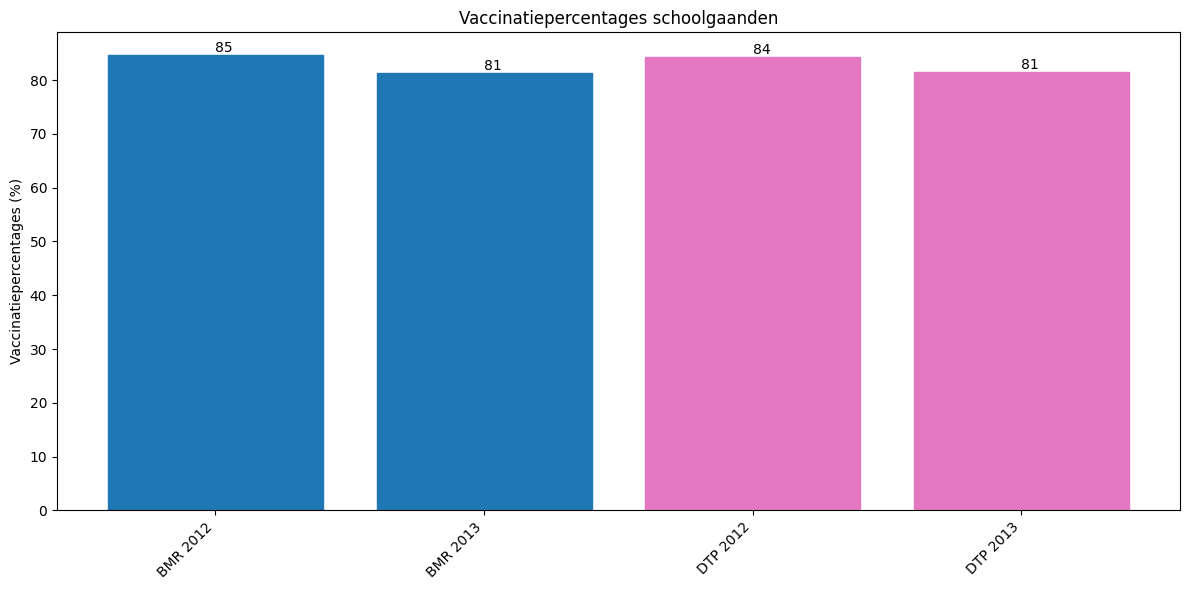

In [80]:
# Create a figure with 1 subplot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot the vaccinated percentages
bars = ax.bar(variable_names_schoolgaanden, vaccinated_schoolgaanden)

# Initialize color palette and counters
color = sns.color_palette()
color_nr = 0
iteration_nr = -1

# Annotate bars with the percentage values and set colors
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval), va='bottom')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Set colors for bars
    bar.set_color(color[color_nr])
    if iteration_nr % 2 == 0:
        color_nr += 6
    iteration_nr += 1

# Add title and y-axis label
ax.set_title('Vaccinatiepercentages schoolgaanden')
ax.set_ylabel('Vaccinatiepercentages (%)')

# Show the plot
plt.tight_layout()
plt.savefig('9_Results/Schoolgaanden/Vaccinatiepercentages_schoolgaanden.jpg', dpi=300)
plt.show()

## 7. Visualize geographically

In [81]:
# From df_observaties calculate the percentages of 'Schoolgaanden_status' per unique CBS_Buurtcode_BRP
buurt_percentages = df_observaties.groupby('CBS_Buurtcode_BRP')['Schoolgaanden_status'].value_counts(normalize=True).unstack().fillna(0)

# Reset index
buurt_percentages = buurt_percentages.reset_index()

In [82]:
# Reading GeoPackage file
cbs_df = gpd.read_file('4_Data/Polygons/buurten_2023_v1.shp')

# Replace every -99997 with NaN
cbs_df = cbs_df.replace(-99997, np.nan)

# From every row in 'BU_CODE' remove the first two characters
cbs_df['BU_CODE'] = cbs_df['BU_CODE'].astype(str).str[2:]

# Filter the df_pc4 to only include the relevant municipalities
cbs_df = cbs_df[cbs_df['BU_CODE'].isin(df_observaties['CBS_Buurtcode_BRP'].unique())]

# Define list of relevant municipalities
municipalities = ['Alphen-Chaam',
                  'Altena',
                  'Baarle-Nassau',
                  'Breda',
                  'Drimmelen',
                  'Etten-Leur',
                  'Geertruidenberg',
                  'Halderberge',
                  'Oosterhout',
                  'Zundert',
                  'Moerdijk',
                  'Roosendaal',
                  'Rucphen',
                  'Steenbergen',
                  'Woensdrecht',
                  'Bergen op Zoom']

# Filter the df_pc4 to only include the relevant municipalities
cbs_df = cbs_df[cbs_df['GM_NAAM'].isin(municipalities)]

In [83]:
# Merge polygons with percentages
gdf = cbs_df.merge(buurt_percentages[['CBS_Buurtcode_BRP', 'Vaccinated']], left_on='BU_CODE', right_on='CBS_Buurtcode_BRP', how='left')

# Change proportions to percentages
gdf['Vaccinated'] = (gdf['Vaccinated'] * 100).round(0)

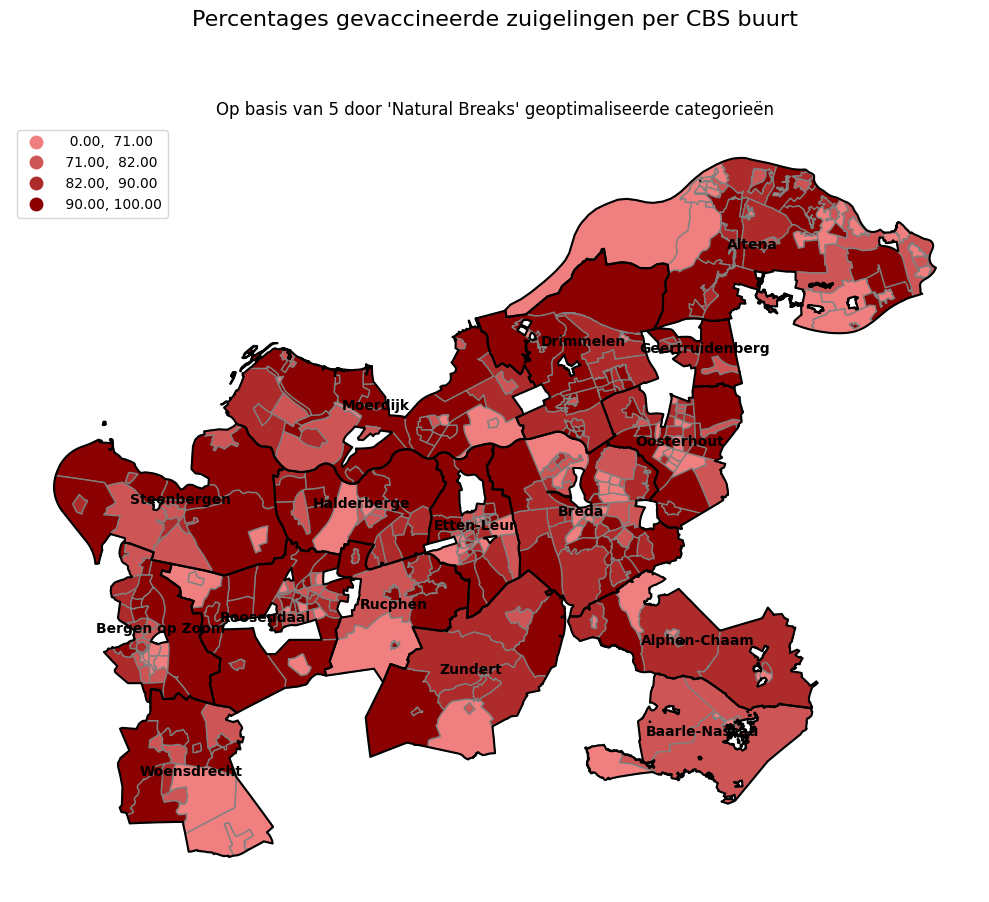

In [84]:
# Create a unidirectional colormap (e.g., from light to dark red)
cmap = mcolors.LinearSegmentedColormap.from_list('unidirectional', ['lightcoral', 'darkred'])

# Dissolve neighborhoods into municipalities
municipalities_gdf = gdf.dissolve(by='GM_NAAM')

# Create a figure and axis with a grey background
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot chloropeth map
gdf.plot(column='Vaccinated',
         cmap=cmap,
         scheme='quantiles',
         k=5,
         legend=True,
         ax=ax,
         edgecolor='grey',
         legend_kwds={'loc': 'upper left'})

# Overlay municipality boundaries with black edges
municipalities_gdf.boundary.plot(ax=ax, edgecolor='black')

# Plot municipality names
for idx, row in municipalities_gdf.iterrows():
    plt.annotate(text=row.name, xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=10, fontweight='bold', color='black')

# Remove axis
ax.set_axis_off()

# Add title
plt.suptitle('Percentages gevaccineerde zuigelingen per CBS buurt', fontsize=16)
plt.title('Op basis van 5 door \'Natural Breaks\' geoptimaliseerde categorieën')
plt.tight_layout()
plt.savefig('9_Results/Schoolgaanden/Vaccinatiepercentages_schoolgaanden_buurten.jpg', dpi=300)
plt.show()

## 8. Save as .pkl

In [85]:
# Save df_observaties as .pkl file
df_observaties.to_pickle('4_Data/Pickles/schoolgaanden_observaties.pkl')

In [86]:
df_observaties.isna().mean()

Postcode                                0.000000
Huisnummer                              0.000000
Clientnummer                            0.000000
B.M.R.                                  0.000000
DKTP                                    0.000000
DKTP-booster                            0.000000
DTP                                     0.000000
Hib                                     0.000000
Pneu                                    0.000000
Excluded                                0.000000
Hepatitis_B                             0.000000
MenACWY/MenC                            0.000000
Geboortejaarmaand                       0.000000
Tweeling                                0.093472
Buurt_BRP                               0.000000
CBS_Buurtcode_BRP                       0.000000
GeboortejaarmaandBiologischeMoeder      0.319712
LeeftijdBiologischeMoederBijGeboorte    0.319712
Geslacht                                0.000000
Geboorteland                            0.093472
Schoolgaanden_status